# Classification

We have seen how you can evaluate a supervised learner with a loss function.  Classification is the learning task where one tried to predict a binary response variable, this can be thought of as the answer to a yes/no question, as in "Will this stock value go up today?".  This is in contrast to regression which predicts a continuous response variable, answering a question such as "What will be the increase in stock value today?".  Classification has some interesting lessons for other machine learning tasks, and in this chapter, we will try to introduce many of the main concepts in classification.

Recall that the supervised learning setting has that the data consists of response variables, $y_i$ and predictor variables $x_i$ for $i=1,\ldots,n$.  In this chapter we will focus on binary classification which we will encode as the binary variable: $y_i \in \{0,1\}$.  We will see that two hueristics can help us understand the basics of evaluating classifiers.

In [375]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import plotnine as p9
import matplotlib.pyplot as plt
import itertools

import warnings
warnings.simplefilter("ignore")

In [376]:
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 6,6

## Evaluating classifiers and heuristics

In this section, we will introduce two heuristics: a similarity-based search (nearest neighbors) and a custom sorting criteria (a output score).  Throughout this chapter we will be using Scikit-learn (Sklearn for short), the main machine learning package in Python.  Recall that the basic pipeline for offline supervised learning is the following, 

- randomly split data into training and testing set
- fit on the training data with predictors and response variables
- predict on the test data with predictors
- observe losses from predictions and the test response variable

Sklearn provides tools for making train-test split via in the Sklearn.model_selection module.  We will use several other modules that we will import,

In [377]:
from sklearn import neighbors, preprocessing, impute, metrics, model_selection, linear_model, svm, feature_selection

Let's read in a dataset from the UCI machine learning repository (CITE),

In [391]:
bank = pd.read_csv('../data/bank.csv',sep=';',na_values=['unknown',999,'nonexistent'])
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
age          4521 non-null int64
job          4483 non-null object
marital      4521 non-null object
education    4334 non-null object
default      4521 non-null object
balance      4519 non-null float64
housing      4521 non-null object
loan         4521 non-null object
contact      3197 non-null object
day          4521 non-null int64
month        4521 non-null object
duration     4521 non-null int64
campaign     4521 non-null int64
pdays        4521 non-null int64
previous     4521 non-null int64
poutcome     816 non-null object
y            4521 non-null object
dtypes: float64(1), int64(6), object(10)
memory usage: 600.5+ KB


The bank dataset contains the outcome of loans in the 'y' variable and many predictors of mixed type.  There is also some missingness.  Before we can go any further exploring the data, it is best to make the train-test split.

In [392]:
bank_tr, bank_te = model_selection.train_test_split(bank,test_size=.33)

Above we specified that roughly 1/3 of the data be reserved for the test set, and the rest for the training set.  First notice that the response variable is binary, and in the training set 4000 of the 4521 records are 'no'.  We call this situation *class imbalance*, in that the percentage of samples with each value of y is not balanced.

In [393]:
bank['y'].describe()

count     4521
unique       2
top         no
freq      4000
Name: y, dtype: object

Consider the following density plot, which shows the density of age conditional on the response variable y.  If we cared equally about predicting 'yes' and 'no' then we may predict that a 'yes' if age exceeds some value like 60 or is below some value such as 28.  We say that "predict yes if age > 60" is a *decision rule*. 

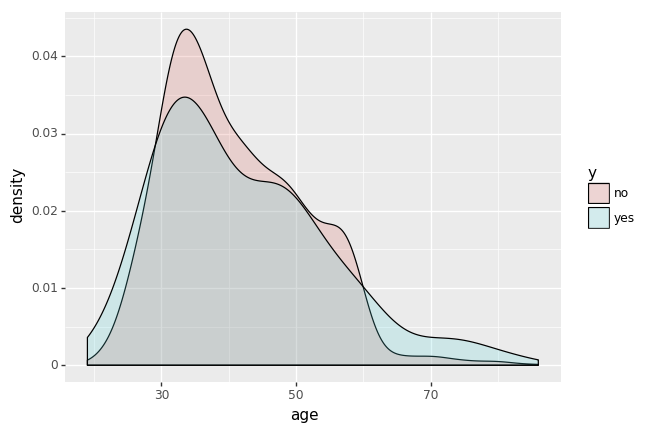

<ggplot: (8786290433137)>

In [7]:
p9.ggplot(bank_tr, p9.aes(x = 'age',fill = 'y')) + p9.geom_density(alpha=.2)

Some explanation is warranted.  We can state more precisely what we mean by "caring equally about predicting 'yes' and 'no'" as conditional on these values let's treat the probability of error equally.  Take the decision rule above, then these error probabilities are
$$
\mathbb P\{ age > 60 | y = no\}, \quad \mathbb P\{ age \le 60 | y = yes\},
$$
which are often called the type 1 and type 2 errors respectively.  If we cared equally about these probabilities then it is reasonable to set the age threshold at 60 since after this threshold it looks like the conditional density of age is greater for $y = yes$.  We can do something similar for a more complicated decision rule such as "predict y=yes if age > 60 or age < 28" which may make even more sense.

In [8]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()



We can make similar considerations for the variables duration and balance below.  It seems that there is some descriminative power for balance, and more significant amount of descriminative power for duration.

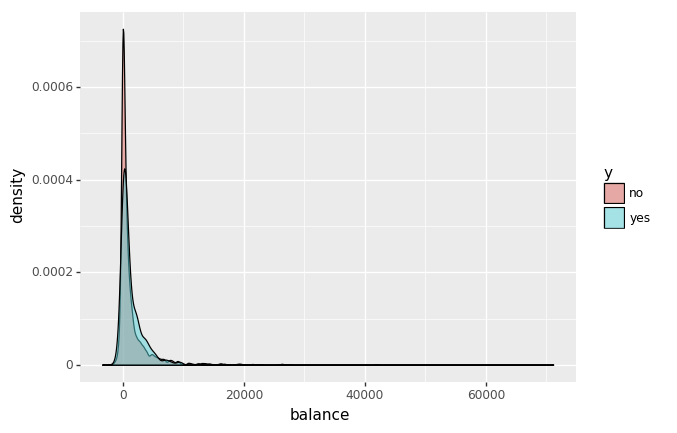

<ggplot: (8786288064972)>

In [9]:
p9.ggplot(bank_tr[['balance','y']].dropna(axis=0)) + p9.aes(x = 'balance',fill = 'y') \
+ p9.geom_density(alpha=.5)

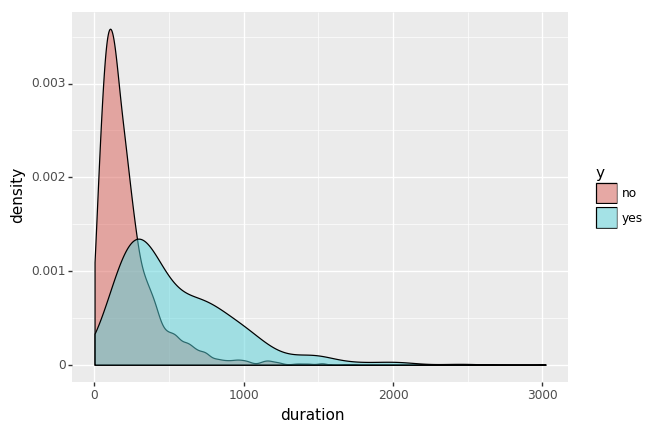

<ggplot: (-9223363250566726186)>

In [10]:
p9.ggplot(bank_tr[['duration','y']].dropna(axis=0)) + p9.aes(x = 'duration',fill = 'y')\
+ p9.geom_density(alpha=.5)

In [11]:
def train_bank_to_xy(bank):
    """standardize and impute training"""
    bank_sel = bank[['age','balance','duration','y']].values
    X,y = bank_sel[:,:-1], bank_sel[:,-1]
    scaler = preprocessing.StandardScaler().fit(X)
    imputer = impute.SimpleImputer(fill_value=0).fit(X)
    trans_prep = lambda Z: imputer.transform(scaler.transform(Z)) 
    X = trans_prep(X)
    y = 2*(y == 'yes')-1
    return (X, y), trans_prep

def test_bank_to_xy(bank, trans_prep):
    """standardize and impute test"""
    bank_sel = bank[['age','balance','duration','y']].values
    X,y = bank_sel[:,:-1], bank_sel[:,-1]
    X = trans_prep(X)
    y = 2*(y == 'yes')-1
    return (X, y)

In [12]:
(X_tr, y_tr), trans_prep  = train_bank_to_xy(bank_tr)
X_te, y_te = test_bank_to_xy(bank_te, trans_prep)

In [13]:
## Set the score to be standardized duration
score_dur = X_te[:,2]

In [14]:
print(plt.style.available)

['bmh', 'seaborn-poster', 'seaborn-whitegrid', 'seaborn', 'seaborn-paper', 'seaborn-talk', 'seaborn-deep', 'fivethirtyeight', 'ggplot', 'tableau-colorblind10', 'seaborn-darkgrid', 'dark_background', 'classic', 'seaborn-bright', 'seaborn-muted', 'seaborn-ticks', '_classic_test', 'seaborn-notebook', 'seaborn-pastel', 'fast', 'Solarize_Light2', 'seaborn-dark', 'seaborn-dark-palette', 'grayscale', 'seaborn-white', 'seaborn-colorblind']


In [15]:
def plot_conf_score(y_te,score,tau):
    y_pred = 2*(score > tau) - 1
    classes = [1,-1]
    conf = metrics.confusion_matrix(y_te, y_pred,labels=classes)
    plot_confusion_matrix(conf, classes)

Confusion matrix, without normalization
[[  66   92]
 [ 118 1216]]


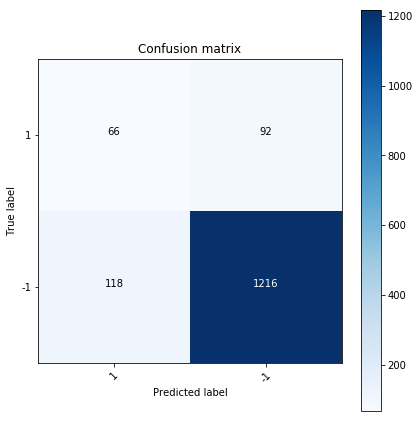

In [16]:
plot_conf_score(y_te,score_dur,1.)

Confusion matrix, without normalization
[[  30  128]
 [  26 1308]]


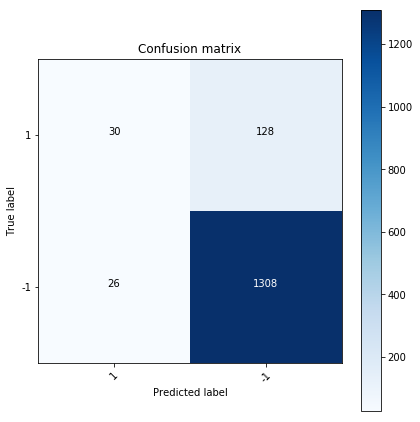

In [17]:
plot_conf_score(y_te,score_dur,2.)

### Confusion matrix and classification metrics

<table style='font-family:"Courier New", Courier, monospace; font-size:120%'>
    <tr><td></td><td>Pred 1</td><td>Pred 0</td></tr>
    <tr><td>True 1</td><td>True Pos</td><td>False Neg</td></tr>
    <tr><td>True 0</td><td>False Pos</td><td>True Neg</td></tr>
</table>

$$
\textrm{FPR} = \frac{FP}{FP+TN}
$$
$$
\textrm{TPR, Recall} = \frac{TP}{TP + FN}
$$
$$
\textrm{Precision} = \frac{TP}{TP + FP}
$$

Confusion matrix, without normalization
[[  91   67]
 [ 199 1135]]


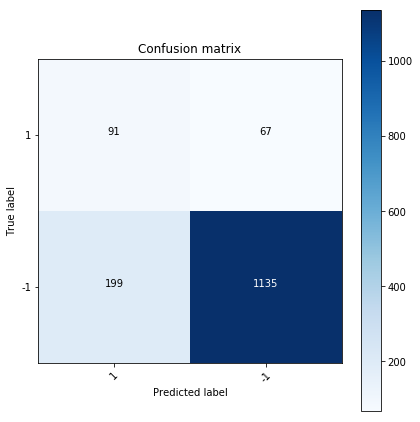

In [18]:
plot_conf_score(y_te,score_dur,.5)

## Searching

### (pseudo-)Metrics

- $d(x_i,x_j) = 0$: most similar
- $d(x_i,x_j)$ larger: less similar

### K nearest neighbors:

- For a test point $x_{n+1}$
- Compute distances to $x_1,\ldots,x_n$
- Sort training points by distance
- return K closest

In [19]:
## Fit and find NNs
nn = neighbors.NearestNeighbors(n_neighbors=10,metric="l2")
nn.fit(X_tr)
dists, NNs = nn.kneighbors(X_te)

In [20]:
NNs[1], y_tr[NNs[1]].mean(), y_te[1]

(array([1300, 2642, 2101,  243,  858, 2395,   75, 1714, 1731,  650]), -1.0, -1)

Confusion matrix, without normalization
[[  81   77]
 [ 166 1168]]


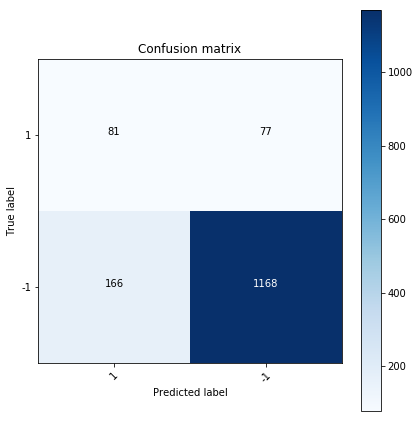

In [21]:
score_nn = np.array([(y_tr[knns] == 1).mean() for knns in NNs])

plot_conf_score(y_te,score_nn,.2)

In [22]:
nn = neighbors.KNeighborsClassifier(n_neighbors=10)
nn.fit(X_tr, y_tr)
score_nn = nn.predict_proba(X_te)[:,1]

Confusion matrix, without normalization
[[  81   77]
 [ 166 1168]]


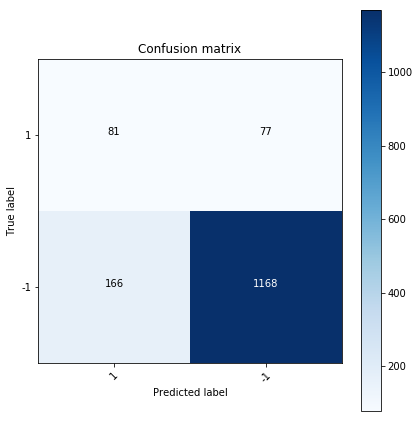

In [23]:
plot_conf_score(y_te,score_nn,.2)

In [24]:
def print_top_k(score_dur,y_te,k_top):
    ordering = np.argsort(score_dur)[::-1]
    print("k: score, y")
    for k, (yv,s) in enumerate(zip(y_te[ordering],score_dur[ordering])):
        print("{}: {}, {}".format(k,s,yv))
        if k >= k_top - 1:
            break

In [25]:
print_top_k(score_dur,y_te,10)

k: score, y
0: 9.558817462333929, 1
1: 6.601767982396253, -1
2: 5.9226004889396, -1
3: 5.632618862519905, -1
4: 5.560123455914981, 1
5: 5.3388216883841615, 1
6: 5.128966564001488, 1
7: 5.018315680236078, 1
8: 4.777936174125015, -1
9: 4.7321496015324325, -1


### Confusion matrix and metrics

<table style='font-family:"Courier New", Courier, monospace; font-size:120%'>
    <tr><td></td><td>Pred 1</td><td>Pred -1</td></tr>
    <tr><td>True 1</td><td>True Pos</td><td>False Neg</td></tr>
    <tr><td>True -1</td><td>False Pos</td><td>True Neg</td></tr>
</table>

$$
\textrm{FPR} = \frac{FP}{FP+TN}
$$
$$
\textrm{TPR, Recall} = \frac{TP}{TP + FN}
$$
$$
\textrm{Precision} = \frac{TP}{TP + FP}
$$

In [26]:
plt.style.use('ggplot')

Text(0.5, 1.0, "ROC for 'duration'")

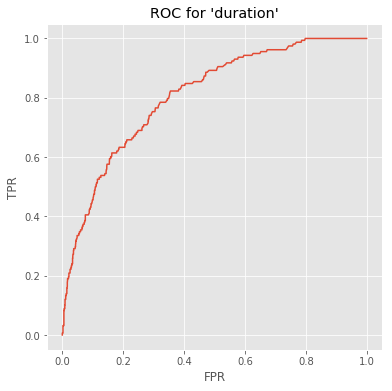

In [27]:
fpr_dur, tpr_dur, threshs = metrics.roc_curve(y_te,score_dur)
plt.figure(figsize=(6,6))
plt.plot(fpr_dur,tpr_dur)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("ROC for 'duration'")

In [28]:
def plot_temp():
    plt.figure(figsize=(6,6))
    plt.plot(fpr_dur,tpr_dur,label='duration')
    plt.plot(fpr_nn,tpr_nn,label='knn')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
    plt.title("ROC")

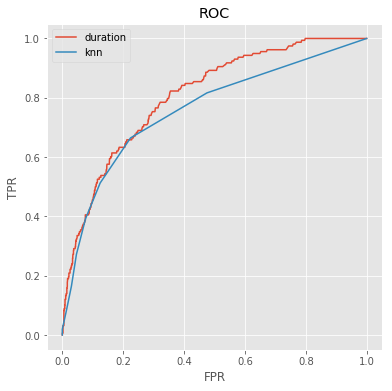

In [29]:
fpr_nn, tpr_nn, threshs = metrics.roc_curve(y_te,score_nn)
plot_temp()

In [30]:
def plot_temp():
    plt.figure(figsize=(6,6))
    plt.plot(rec_dur,prec_dur,label='duration')
    plt.plot(rec_nn,prec_nn,label='knn')
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.legend()
    plt.title("PR curve")

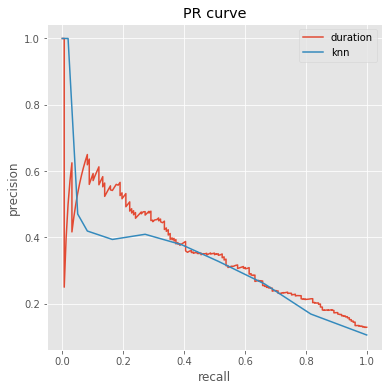

In [31]:
prec_dur, rec_dur, threshs = metrics.precision_recall_curve(y_te,score_dur)
prec_nn, rec_nn, threshs = metrics.precision_recall_curve(y_te,score_nn)
plot_temp()

- ROC should be in top left
- PR should be large for all recall values

## Linear classifiers

In the above analysis we chose a variable (duration) and used that as the score.  Let's consider another score which is a linear combination such as $0.2 (age) + 0.8 (duration)$ and compare the training errors of these.  If we took this to its logical conclusion, we would search in an automated way for the exact coefficients.  This is precisely what linear classifiers, such as logistic regression, support vector machines, and the perceptron do.  This would be based on the training dataset only and hence, the test error is an unbiased estimate of the true risk (the expected loss).  We have already seen the form for a linear classifier, where the score function is $\hat s(x) = \hat \beta_0 + \hat \beta^\top x$ where $\beta$ is learned.  With this score function in hand we can write the predict function as $\hat y(x) = \textrm{sign} (\hat s(x))$.

### Optimization and training loss

Why the different classification methods if they are all linear classifiers?  Throughout we will make a distinction between the training loss, which is the loss used for training, and the test loss, the loss used for testing.  We have already seen that they can be different when we trained a regressor with square error loss, but tested with the 0-1 loss in Statistical Learning Machines.  In regression, we know that ordinary least squares minimizes the training square error, and these classifiers work in a similar way, except each uses a different training loss.  We have already seen the 0-1 loss, recall that it takes the form,
$$
\ell_{0/1} (\hat y_{i}, y_i) = \left\{ \begin{array}{ll}
1,& \textrm{ if } \hat y_i \ne y_i\\
0,& \textrm{ if } \hat y_i = y_i
\end{array} \right.
$$
Why not use this loss function for training?  To answer this we need to take a quick detour to describe optimization, also known as mathematical programming.

Suppose that we have some parameter $\beta$ and a function of that parameter $F(beta)$ that takes real values (we will allow possibly infinite values as well).  Furthermore, suppose that $\beta$ is constrained to be within the set $\mathcal B$.  Then an optimization (minimization) program takes the form 
$$
\textrm{Find } \hat \beta \textrm{ such that } \hat \beta \in \mathcal B \textrm{ and } F(\hat \beta) \le F(\beta) \textrm{ for all } \beta \in \mathcal B.
$$
We can rewrite this problem more succinctly as
$$
\min_{\beta \in \mathcal B}. F(\beta),
$$
where $\min.$ stands for minimize.  An optimization program is an idealized program, and is not itself an algorithm.  It says nothing about how to find it, and there are many methods for finding the minimum based on details about the function $F$ and the constraint set $\mathcal B$.

Some functions are hard to optimize, especially discontinuous functions.  Most optimization algorithms work by starting with an initial value of $\beta$ and iteratively moving it in a way that will tend to decrease $F$.  When a function is discontinuous then these moves can have unpredictable consequences.  Returning to our question, suppose that we wanted to minimize training error with a 0-1 training loss.  Then this could be written as the optimization program,
$$
\min_{\beta \in \mathbb R^{p+1}}.\frac{1}{n_0} \sum_{i=1}^{n_0} 1 \{ \textrm{sign}(\beta^\top x_i) \ne y_i \}.
\tag{0-1 min}
$$
This optimization is discontinuous because it is the sum of discontinuous functions---the indicator can suddenly jump from 0 to 1 with an arbitrarily small movement of $\beta$.

**Note:** Let us introduce the indicator notation, 
$$
1\{ {\rm condition} \} = \left\{ \begin{array}{ll}
1,& \textrm{ if condition is true}\\
0,& \textrm{ if condition is not true}
\end{array} \right.
$$
We will suppress the intercept term by assuming that the first variable is an intercept variable.  Specifically, if $x_1,\ldots,x_p$ were our original predictor variables, then we can include $x_0 = 1$ then if $\tilde x = (x_0,x_1,\ldots,x_p)$ and $\tilde \beta = (\beta_0, \beta_1, \ldots, \beta_p)$ we have that
$$
\tilde \beta^\top \tilde x = \beta_0 + \beta^\top x.
$$
Hence, without loss of generality, we can think of $\beta$ and $x$ as being $(p+1)$-dimensional vectors, and no longer treat the intercept as a special parameter.

Let's simulate some data for which a linear classifier will do well.  We will use this to introduce the two main methods: logistic regression and support vector machines.

In [32]:
def lm_sim(N = 100):
    """simulate a binary response and two predictors"""
    X1 = (np.random.randn(N*2)).reshape((N,2)) + np.array([2,3])
    X0 = (np.random.randn(N*2)).reshape((N,2)) + np.array([.5,1.5])
    y = - np.ones(N*2)
    y[:N]=1
    X = np.vstack((X1,X0))
    return X, y, X0, X1

In [33]:
X_sim,y_sim,X0,X1 = lm_sim()

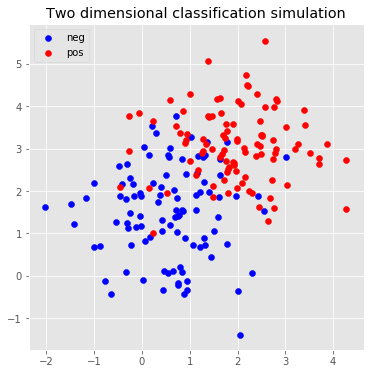

In [34]:
plt.scatter(X0[:,0],X0[:,1],c='b',label='neg')
plt.scatter(X1[:,0],X1[:,1],c='r',label='pos')
plt.title("Two dimensional classification simulation")
_ = plt.legend(loc=2)

The red dots correspond to ``Y = +1`` and blue is ``Y = -1``.  We can see that a classifier that classifies as +1 when the point is in the upper right of the coordinate system should do pretty well.  We could propose several $\beta$ vectors to form linear classifiers and observe their training errors, finally selecting the one that minimized the training error.    We have seen that a linear classifier has a separator hyperplane (a line in 2 dimensions).  To find out what the prediction the classifier makes for a point one just needs to look at which side of the hyperplane it falls on.  Consider a few such lines.

In [35]:
lr_sim = linear_model.LogisticRegression()
lr_sim.fit(X_sim,y_sim)

beta1 = lr_sim.coef_[0,0]
beta2 = lr_sim.coef_[0,1]
beta0 = lr_sim.intercept_

mults=0.8
T = np.linspace(-1,4,100)
x2hat = -(beta0 + beta1*T) / beta2
line1 = -(beta0 + np.random.randn(1)*2 + 
          (beta1 + np.random.randn(1)*mults) *T) / (beta2 + np.random.randn(1)*mults)
line2 = -(beta0 + np.random.randn(1)*2 + 
          (beta1 + np.random.randn(1)*mults) *T) / (beta2 + np.random.randn(1)*mults)
line3 = -(beta0 + np.random.randn(1)*2 + 
          (beta1 + np.random.randn(1)*mults) *T) / (beta2 + np.random.randn(1)*mults)

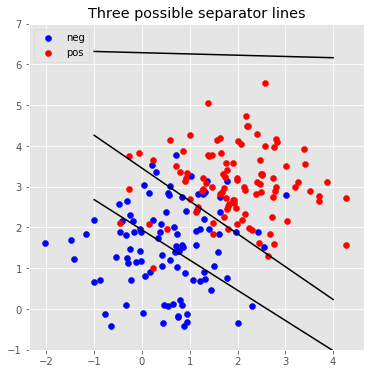

In [36]:
plt.scatter(X0[:,0],X0[:,1],c='b',label='neg')
plt.scatter(X1[:,0],X1[:,1],c='r',label='pos')
plt.plot(T,line3,c='k')
plt.plot(T,line1,c='k')
plt.plot(T,line2,c='k')
plt.ylim([-1,7])
plt.title("Three possible separator lines")
_ = plt.legend(loc=2)

One of these will probably do a better job at separating the training data than the others, but if we wanted to do this over all possible $\beta \in \mathbb R^{p+1}$ then we need to solve the program (0-1 min) above, which we have already said is a hard objective to optimize.  Logistic regression regression uses a different loss function that can be optimized in several ways, and we can see the resulting separator line below.  (It is outside the scope of this chapter to introduce specific optimization methods.)

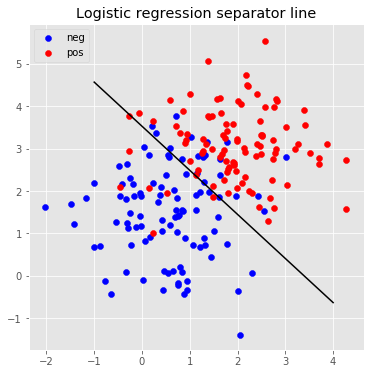

In [37]:
plt.scatter(X0[:,0],X0[:,1],c='b',label='neg')
plt.scatter(X1[:,0],X1[:,1],c='r',label='pos')
plt.plot(T,x2hat,c='k')
plt.title("Logistic regression separator line")
_ = plt.legend(loc=2)

The points above this line are predicted as a +1, and so we can also isolate those points that we classified incorrectly.  The 0-1 loss counts each of these points as a loss of 1.

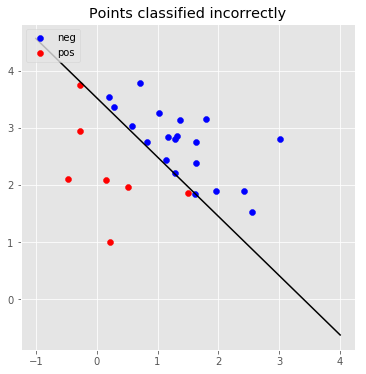

In [38]:
N = 100
y_hat = lr_sim.predict(X_sim)
plt.scatter(X0[y_hat[N:] == 1,0],X0[y_hat[N:] == 1,1],c='b',label='neg')
plt.scatter(X1[y_hat[:N] == -1,0],X1[y_hat[:N] == -1,1],c='r',label='pos')
plt.plot(T,x2hat,c='k')
plt.title("Points classified incorrectly")
_ = plt.legend(loc=2)

Logistic regression uses a loss function that mimics some of the behavior of the 0-1 loss, but is not discontinuous.  In this way, it is a surrogate loss, that acts as a surrogate for the 0-1 loss.  It turns out that it is one of a few nice options for surrogate losses.  Notice that we can rewrite the 0-1 loss for a linear classifier as
$$
\ell_{0/1}(\beta,x_i,y_i) = 1 \{ y_i \beta^\top x_i < 0 \}.
$$
Throughout we will denote our losses as functions of $\beta$ to reflect the fact that we are only considering linear classifiers.
The logistic loss and the hinge loss are also functions of $y_i \beta^\top x_i$, they are 
$$
\ell_{L} (\beta, x_i, y_i) = \log(1 + \exp(-y_i \beta^\top x_i))
\tag{logistic}
$$
and 
$$
\ell_{H} (\beta, x_i, y_i) = (1 - y_i \beta^\top x_i))_+
\tag{hinge}
$$
where $a_+ = a 1\{ a > 0\}$ is the positive part of the real number $a$.

If we are free to select training loss functions, then why not square error loss?  For example, we could choose
$$
\ell_{S} (\beta, x_i, y_i) = (y_i - \beta^\top x_i))^2 = (1 - y_i \beta^\top x_i))^2.
\tag{square error}
$$
In order to motivate the use of these, let's plot the losses as a function of $y_i \beta^\top x_i$.

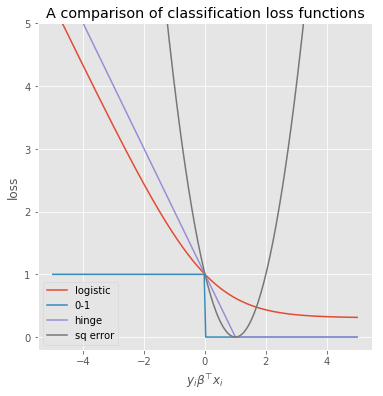

In [39]:
z_range = np.linspace(-5,5,200)
zoloss = z_range < 0
l2loss = (1-z_range)**2.
hingeloss = (1 - z_range) * (z_range < 1)
logisticloss = np.log(1 + np.exp(-z_range))
plt.plot(z_range, logisticloss + 1 - np.log(2.),label='logistic')
plt.plot(z_range, zoloss,label='0-1')
plt.plot(z_range, hingeloss,label='hinge')
plt.plot(z_range, l2loss,label='sq error')
plt.ylim([-.2,5])
plt.xlabel(r'$y_i \beta^\top x_i$')
plt.ylabel('loss')
plt.title('A comparison of classification loss functions')
_ = plt.legend()

Comparing these we see that the logistic loss is smooth---it has continuous first and second derivatives---and it is decreasing as $y_i \beta^\top x_i$ is increasing.  The hinge loss is interesting, it is continuous, but it has a discontinuous first derivative.  This changes the nature of optimization algorithms that we will tend to use.  On the other hand the hinge loss is zero for large enough $y_i \beta^\top x_i$, as opposed to the logistic loss which is always non-zero.  Below we depict these two losses by weighting each point by the loss for the fitted classifier.

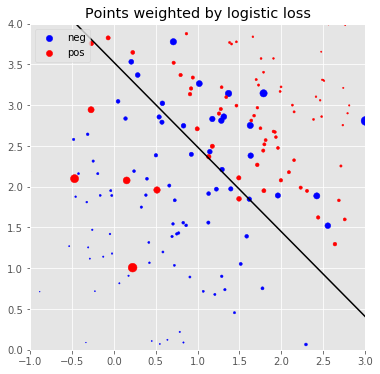

In [40]:
z_log = y_sim*lr_sim.decision_function(X_sim)
logisticloss = np.log(1 + np.exp(-z_log))
plt.scatter(X0[:,0],X0[:,1],s=logisticloss[N:]*30.,c='b',label='neg')
plt.scatter(X1[:,0],X1[:,1],s=logisticloss[:N]*30.,c='r',label='pos')
plt.plot(T,x2hat,c='k')
plt.xlim([-1,3])
plt.ylim([0,4])
plt.title("Points weighted by logistic loss")
_ = plt.legend(loc=2)

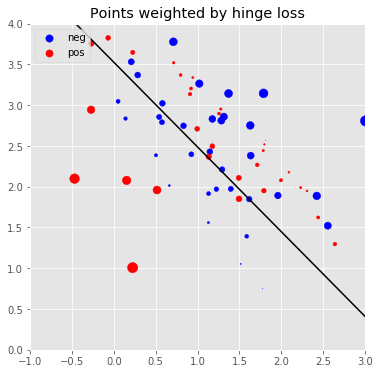

In [41]:
hingeloss = (1-z_log)*(z_log < 1)
plt.scatter(X0[:,0],X0[:,1],s=hingeloss[N:]*30.,c='b',label='neg')
plt.scatter(X1[:,0],X1[:,1],s=hingeloss[:N]*30.,c='r',label='pos')
plt.plot(T,x2hat,c='k')
plt.xlim([-1,3])
plt.ylim([0,4])
plt.title("Points weighted by hinge loss")
_ = plt.legend(loc=2)

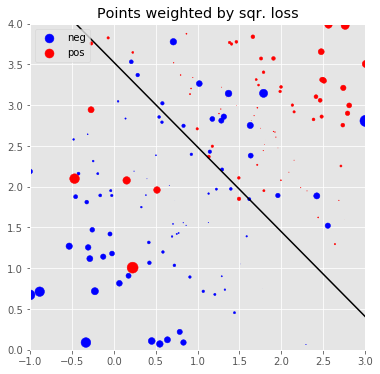

In [42]:
l2loss = (1-z_log)**2.
plt.scatter(X0[:,0],X0[:,1],s=l2loss[N:]*10.,c='b',label='neg')
plt.scatter(X1[:,0],X1[:,1],s=l2loss[:N]*10.,c='r',label='pos')
plt.plot(T,x2hat,c='k')
plt.xlim([-1,3])
plt.ylim([0,4])
plt.title("Points weighted by sqr. loss")
_ = plt.legend(loc=2)

We see that for the logistic loss the size is vanishing when the points are on the wrong side of the separator hyperplane.  The hinge loss is zero if we are sufficiently far from the hyperplane.  The square error loss has increased weight for those far from the hyperplane, even if they are correctly classified.  Hence, square error loss is not a good surrogate for 0-1 loss.

Support vector machines are algorithmically instable if we only try to minimize the training error with the hinge loss.  So, we add an additional term to make the optimization somewhat easier, which we call a ridge regularization.  Regularization is the process of adding a term to the objective that biases the results in a certain way.  Ridge regularization means that we minimize the following objective for our loss,
$$
\min_{\beta \in \mathbb R^{p+1}}. \frac 1n \sum_{i=1}^n \ell(\beta,x_i,y_i) + \lambda \sum_{j=1}^p \beta_j^2.
$$
This has the effect of biasing the $\hat \beta_j$ towards 0 for $j=1,\ldots,p$.  Typically, this has little effect on the test error, except for when $\lambda$ is too large, but it does often make the result more computationally stable.

In Scikit-learn we can initialize a logistic regression instance with ``linear_model.LogisticRegression``.  For historical reasons they parametrize the ridge regularization with the reciprocal of the $\lambda$ parameter that they call C.  All supervised learners in Scikit-learn have a fit and predict method.  Let's apply this to the bank data using the predictors age, balance, and duration.

In [43]:
lamb = 1.
lr = linear_model.LogisticRegression(penalty='l2', C = 1/lamb)
lr.fit(X_tr,y_tr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

We can then predict on the test set and see what the resulting 0-1 test error is.

In [44]:
yhat = lr.predict(X_te)
(yhat != y_te).mean()

0.10254691689008043

On the other hand we can extract a score by using the coefficients themselves.  We can also extract the ROC and PR curves for this score.

In [45]:
score_lr = X_te @ lr.coef_[0,:]
fpr_lr, tpr_lr, threshs = metrics.roc_curve(y_te,score_lr)
prec_lr, rec_lr, threshs = metrics.precision_recall_curve(y_te,score_lr)

We can also do this same procedure for SVMs.  Notice that we set the  ``kernel='linear'`` argument in SVC.  SVMs in general can use a kernel to make them non-linear classifiers, but we want to only consider linear classifiers here.

In [46]:
lamb = 1.
svc = svm.SVC(C = 1/lamb,kernel='linear')
svc.fit(X_tr,y_tr)
yhat = svc.predict(X_te)
score_svc = X_te @ svc.coef_[0,:]
fpr_svc, tpr_svc, threshs = metrics.roc_curve(y_te,score_svc)
prec_svc, rec_svc, threshs = metrics.precision_recall_curve(y_te,score_svc)
(yhat != y_te).mean()

0.10589812332439678

We see that SVMs achieves a slightly lower 0-1 test error.  We can also compare these two methods based on the ROC and PR curves.

Text(0.5, 1.0, 'ROC curve comparison')

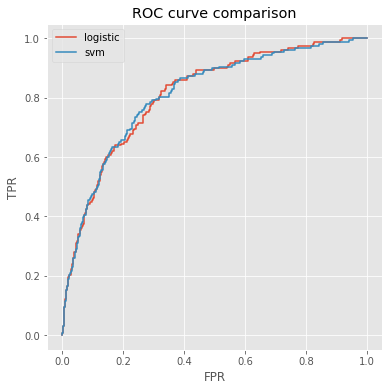

In [47]:
plt.figure(figsize=(6,6))
plt.plot(fpr_lr,tpr_lr,label='logistic')
plt.plot(fpr_svc,tpr_svc,label='svm')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.title("ROC curve comparison")

Text(0.5, 1.0, 'PR curve comparison')

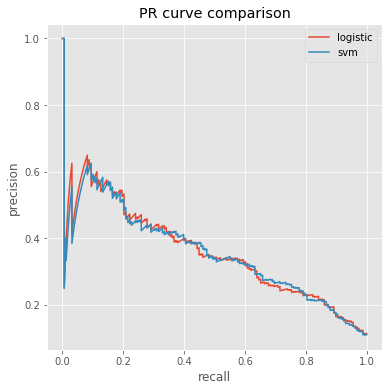

In [48]:
plt.figure(figsize=(6,6))
plt.plot(rec_lr,prec_lr,label='logistic')
plt.plot(rec_svc,prec_svc,label='svm')
plt.xlabel('recall')
plt.ylabel('precision')
plt.legend()
plt.title("PR curve comparison")

Despite having a lower misclassification rate (0-1 test error), the ROC for logistic regression is uniformly better than that for SVMs, and for all but the lowest recall regions, the precision is better for logistic regression.  We might conclude that despite the misclassification rate, logistic regression is the better classifier in this case.

### Tuning the ridge penalty $\lambda$

Let's consider how regularized logistic regression performs with different values of $\lambda$.  It is quite common for selection of $\lambda$ to not improve the test error in any significant way for ridge regularization.  We mainly use it for computational reasons. 

In [49]:
def test_lamb(lamb):
    """Test error for logistic regression and different lambda"""
    lr = linear_model.LogisticRegression(penalty='l2', C = 1/lamb)
    lr.fit(X_tr,y_tr)
    yhat = lr.predict(X_te)
    return (yhat != y_te).mean()

In [60]:
test_frame = pd.DataFrame({'lamb':lamb,'error':test_lamb(lamb)} for lamb in 1.5**np.arange(-5,30))

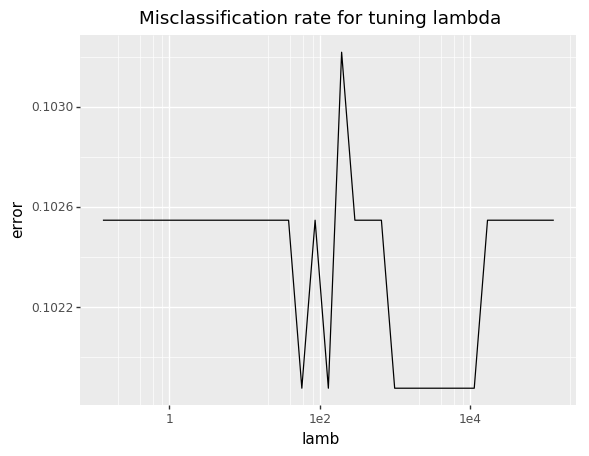

<ggplot: (8786287803603)>

In [61]:
p9.ggplot(test_frame,p9.aes(x='lamb',y='error')) + p9.geom_line() + p9.scale_x_log10()\
+ p9.labels.ggtitle('Misclassification rate for tuning lambda')

In [69]:
(y_te == 1).mean()

0.10589812332439678

In the above plot, we see that there is not a significant change in error as we increase $\lambda$, which could be for a few reasons.  The most likely explanation is that if we look only at misclassification rate, it is hard to beat predicting every observation as a -1.  Due to the class imbalance, the proportion of 1's is 0.106 which is quite close to the test error in this case, so the classifier only needs to do better than random on a very small proportion of points to beat this baseline rate. 

We can also do the same thing for Precision, and obtain a similar result.

In [568]:
def get_prec(lr,X,y,K):
    """Find precision for top K"""
    
    lr_score = X @ lr.coef_[0,:]
    sc_sorted_id = np.argsort(lr_score)[::-1]
    return np.mean(y[sc_sorted_id[:K]] == 1) 

def prec_lamb(lamb):
    """Test error for logistic regression and different lambda"""
    lr = linear_model.LogisticRegression(penalty='l2', C = 1/lamb)
    lr.fit(X_tr,y_tr)
    prec_K = int(.12 * len(y_te))
    return get_prec(lr,X_te,y_te,prec_K)

In [569]:
test_frame = pd.DataFrame({'lamb':lamb,'prec':prec_lamb(lamb)} for lamb in 1.5**np.arange(-5,30))

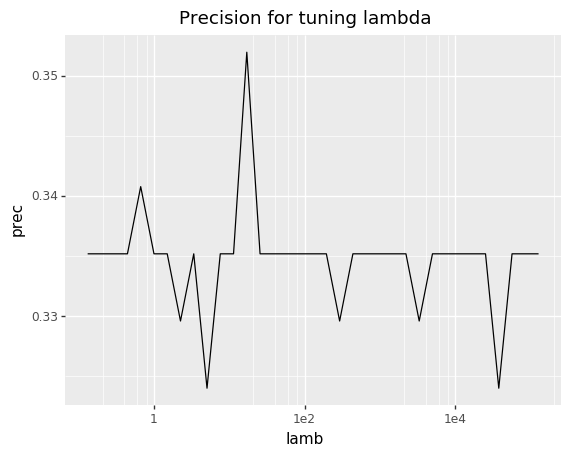

<ggplot: (8786272834729)>

In [570]:
p9.ggplot(test_frame,p9.aes(x='lamb',y='prec')) + p9.geom_line() + p9.scale_x_log10()\
+ p9.labels.ggtitle('Precision for tuning lambda')

### Class Weighting

Recall that the response variable in the bank data had significant class imbalance, with a prevelence of "no" responses (encoded as -1).  One way that we can deal with class imbalance is by weighting differently the losses for the different classes.  Specifically, specify a class weighting function $\pi(y)$ such that $\pi(1)$ is the weight applied to the positive class and $\pi(-1) = 1-\pi(1)$ is the weight on the negative classes.  Then the objective for our classifier becomes
$$
\frac 1n \sum_{i=1}^n \pi(y_i) \ell(\beta,x_i,y_i).
$$
In the event that $\pi(1) > \pi(-1)$ then we will put more emphasis on classifying the 1's correctly.  By default, $\pi(1) = 0.5$ which is equivalent to no weighting.  This may be appropriate if we have class imbalance with fewer 1's.  Let's consider what these weighted losses now look like as a function of $\beta^\top x_i$ for logistic and 0-1 loss (below $\pi(1) = .8$).

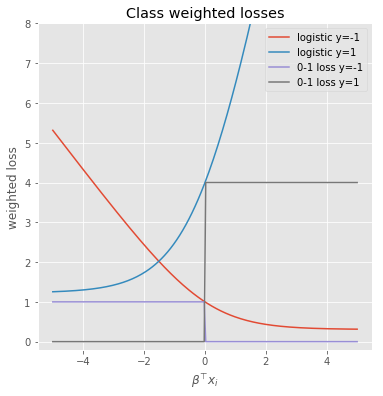

In [62]:
alpha = 4.
zolossn = z_range < 0
zolossp = z_range > 0
logisticlossn = np.log(1 + np.exp(-z_range))
logisticlossp = np.log(1 + np.exp(z_range))
plt.plot(z_range, logisticlossn + 1 - np.log(2.),label='logistic y=-1')
plt.plot(z_range, alpha*(logisticlossp + 1 - np.log(2.)),label='logistic y=1')
plt.plot(z_range, zolossn,label='0-1 loss y=-1')
plt.plot(z_range, alpha*zolossp,label='0-1 loss y=1')
plt.ylim([-.2,8])
plt.title('Class weighted losses')
plt.xlabel(r'$\beta^\top x_i$')
plt.ylabel('weighted loss')
_ = plt.legend()

Hence, the loss is higher if we misclassify the 1's versus the -1's.  We can also visualize what this would do for the points in our two dimensional simulated dataset.

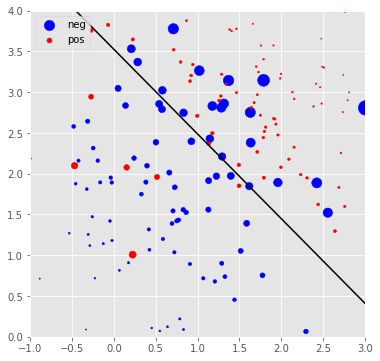

In [63]:
y_hat = lr_sim.predict(X_sim)
z_log = y_sim*lr_sim.decision_function(X_sim)
logisticloss = np.log(1 + np.exp(-z_log))
plt.scatter(X0[:,0],X0[:,1],s=alpha*logisticloss[N:]*20.,c='b',label='neg')
plt.scatter(X1[:,0],X1[:,1],s=logisticloss[:N]*20.,c='r',label='pos')
plt.plot(T,x2hat,c='k')
plt.xlim([-1,3])
plt.ylim([0,4])
_ = plt.legend(loc=2)

In the above plot we are weighting the loss for negative points 4 times as much as positive points.  How do we choose the amount that we weight by?  Typically, this is chosen to be inversely proportional to the proportion of points for that class.  In Scikit-learn this is achieved using ``class_weight='balanced'``.  Below we fit the balanced logistic regression and SVM and compare to the old version in PR curve.

In [54]:
lr_bal = linear_model.LogisticRegression(class_weight='balanced')
lr_bal.fit(X_tr,y_tr)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

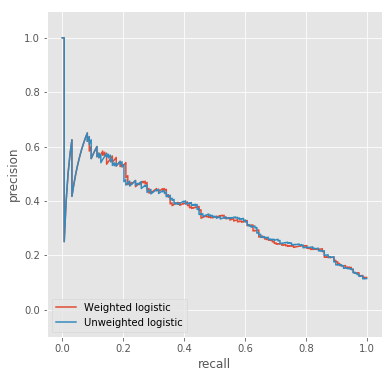

In [55]:
z_log = lr_bal.predict_proba(X_te)[:,1]
plt.figure(figsize=(6,6))
prec_lr_bal, rec_lr_bal, _ = metrics.precision_recall_curve(y_te,z_log)
plt.plot(rec_lr_bal,prec_lr_bal,label='Weighted logistic')
plt.plot(rec_lr,prec_lr,label='Unweighted logistic')
plt.xlabel('recall')
plt.ylabel('precision')
plt.ylim([-.1,1.1])
plt.legend(loc=3)
_ = plt.plot()

In [ ]:
svc_bal = svm.SVC(C = 1/lamb,kernel='linear',class_weight='balanced')
svc_bal.fit(X_tr,y_tr)

<Figure size 432x432 with 0 Axes>

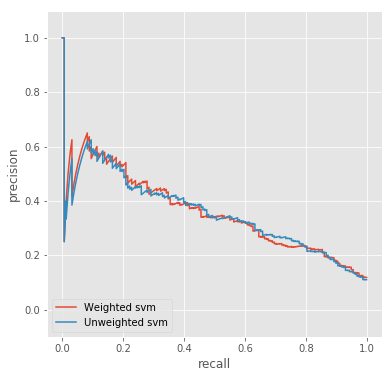

In [64]:
plt.figure(figsize=(6,6))
z_svm = svc_bal.decision_function(X_te)
plt.figure(figsize=(6,6))
prec_svm_bal, rec_svm_bal, _ = metrics.precision_recall_curve(y_te,z_svm)
plt.plot(rec_svm_bal,prec_svm_bal,label='Weighted svm')
plt.plot(rec_svc,prec_svc,label='Unweighted svm')
plt.xlabel('recall')
plt.ylabel('precision')
plt.ylim([-.1,1.1])
plt.legend(loc=3)
_ = plt.plot()

It seems that in this case class balancing is not essential, and does not substantially change the results.

**Aside:** This interpretation of logistic regression and SVMs is not the standard first introduction to these two methods.  Instead of introducing surrogate losses, it is common to introduce the logistic model to motivate logistic regression.  Under a particular statistical model, logistic regression is a maximum likelihood estimator.  Also, support vector machines are often motivated by considering the separator hyperplane and trying to maximize the distance that the points are from that plane.  This interpretation is complicated by the fact that if the dataset is not perfectly separated, then we need to introduce 'slack' variables that allow some slack to have misclassified points.  We find that compared to these, the surrogate loss interpretation is simpler and often more enlightening.

In [418]:
K_max = np.argmax(prec_svc)

## Feature engineering and overfitting

Feature engineering is the process of constructing new variables from other variables or unstructured data.  There are a few reasons why you might want to do this:

1. Your data is unstructured, text, or categorical and you need your predictors to be numeric;
2. due to some domain knowledge you have good guesses at important predictors that you need to construct;
3. or you want to turn a linear classifier into a non-linear classifier with a non-linear transformation.

We will discuss dealing with unstructured and text data more in later chapters, but for now, let's consider dealing with categorical data.  The most common way to encode categorical data is to create dummy variables for each category.  This is called the one-hot encoding, and in Scikit-learn it is ``preprocessing.OneHotEncoder``.  We can see the unique values for the marital variable in the bank data.

In [394]:
bank_tr['marital'].unique()

array(['married', 'single', 'divorced'], dtype=object)

We initialize the encoder which when initialized does nothing to the data.  We allow it to ignore NAs and output a dense matrix.  When we fit on the data it determines the unique values and assigns dummy variables for the values.

In [395]:
OH_marital = preprocessing.OneHotEncoder(handle_unknown='ignore',sparse=False)
OH_marital.fit(bank_tr[['marital']])
marital_trans = OH_marital.transform(bank_tr[['marital']])

Let's look at the output of the transformation.

In [396]:
marital_trans[[0,10,17],:]

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

Then look at the actual variable.

In [397]:
bank_tr.iloc[:3,2]

1572    married
3817    married
43      married
Name: marital, dtype: object

It seems that the first dummy is assigned to 'divorced', the second to 'married', and the third to 'single'.  This method cannot handle missing data, so a tool such as ``impute.SimpleImputer`` should be used first.  All of these methods are considered transformations, and they have fit methods.  The reason for this interface design is to make it so that we can fit on the training set and then transform can be applied to the test data.  

In the following, we will create an imputer and encoder for each continuous variable, then transform the training data.

In [398]:
## TRAINING TRANSFORMATIONS

## extract y and save missingness
y_tr = bank_tr['y']
del bank_tr['y']
y_tr = 2*(y_tr == 'yes').values - 1

In [399]:
bank_nas_tr = bank_tr.isna().values

In [400]:
# find object and numerical column names
obj_vars = bank_tr.dtypes[bank_tr.dtypes == 'object'].index.values
num_vars = bank_tr.dtypes[bank_tr.dtypes != 'object'].index.values

In [401]:
# create imputers and encoders for categorical vars and fit
obj_imp = [impute.SimpleImputer(strategy='most_frequent').fit(bank_tr[[var]])\
           for var in obj_vars]

obj_tr_trans = [imp.transform(bank_tr[[var]]) for imp,var in zip(obj_imp,obj_vars)]

obj_OH = [preprocessing.OneHotEncoder(handle_unknown='ignore',sparse=False).fit(var_data)\
          for var_data in obj_tr_trans]

obj_tr_trans = [OH.transform(var_data)[:,:-1] for OH, var_data in zip(obj_OH,obj_tr_trans)]

In [402]:
# Store the variable names associated with transformations
obj_var_names = sum(([var]*trans.shape[1] for var,trans in zip(obj_vars,obj_tr_trans)),[])

We can also apply a fixed transformation the variables.  While this could include multiple variables and encode interactions, we will only use univariate transformations.  The following method applies the transformations,
$x \to x^2$ and $x \to \log(1 + x)$ and combines these with the original numerical dataset.

In [403]:
def fixed_trans(df):
    """selected fixed transformations"""
    return np.hstack([df, df**2, np.log(np.abs(df)+1)])

We can now apply imputation and this fixed transformation to the numerical variables.

In [404]:
# create imputers for numerical vars and fit
num_tr_vals = bank_tr[num_vars]
num_imp = impute.SimpleImputer(strategy='median').fit(num_tr_vals)
num_tr_trans = num_imp.transform(num_tr_vals)
num_tr_trans = fixed_trans(num_tr_trans)

In [405]:
# numerical variable names
num_var_names = list(num_tr_vals.columns.values)*3

I noticed that for various reasons that the standard deviation for some created variables is 0 (probably when there is only one value for a binary variable).  We filter these out in the following lines.

In [406]:
# stack together for training predictors
X_tr = np.hstack(obj_tr_trans + [num_tr_trans,bank_nas_tr])
keep_cols = (X_tr.std(axis=0) != 0)
X_tr = X_tr[:,keep_cols]

The variable names are then also filtered out, this will be used later to be able to identify the variables by their indices in the transformed variables.

In [407]:
var_names = np.array(obj_var_names + num_var_names + list(bank_tr.columns.values))
var_names = var_names[keep_cols]

These transformations can now be applied to the test data.  Because they were all fit with the training data, we do not run the risk of the fitting to the testing data.  It is important to maintain the organization that we fit to the training data first, then transform the test data.

In [408]:
## TESTING TRANSFORMATIONS

y_te = bank_te['y']
del bank_te['y']
y_te = 2*(y_te == 'yes') - 1
y_te = np.array(y_te)

bank_nas_te = bank_te.isna().values

obj_te_trans = [imp.transform(bank_te[[var]]) for imp,var in zip(obj_imp,obj_vars)]
obj_te_trans = [OH.transform(var_data)[:,:-1] for OH, var_data in zip(obj_OH,obj_te_trans)]

num_te_vals = bank_te[num_vars]
num_te_trans = num_imp.transform(num_te_vals)
num_te_trans = fixed_trans(num_te_trans)

X_te = np.hstack(obj_te_trans + [num_te_trans,bank_nas_te])
X_te = X_te[:,keep_cols]

Now we are ready to train our linear classifier, and we will use logistic regression.

In [409]:
lr = linear_model.LogisticRegression()
lr.fit(X_tr,y_tr)

yhat_te = lr.predict(X_te)
yhat_tr = lr.predict(X_tr)

print("""
Training error:{}
Testing error: {}
""".format((yhat_tr != y_tr).mean(), (yhat_te != y_te).mean()))


Training error:0.115549686365137
Testing error: 0.1126005361930295



We output the training error along with the testing 0-1 error.  The testing error is actually lower than the training error.  Notably neither are much larger than the proportion of 1s in the dataset.  This indicates to us that the 0-1 loss is not a very good measure of performance in this imbalanced dataset.  Instead, let's compare the PR curve for these two.

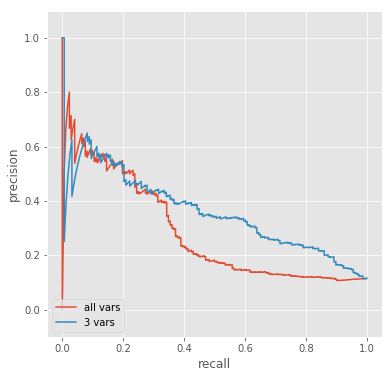

In [528]:
z_log = lr.predict_proba(X_te)[:,1]
plt.figure(figsize=(6,6))
prec, rec, _ = metrics.precision_recall_curve(y_te,z_log)
plt.plot(rec,prec,label='all vars')
plt.plot(rec_lr,prec_lr,label='3 vars')
plt.xlabel('recall')
plt.ylabel('precision')
plt.ylim([-.1,1.1])
plt.legend(loc=3)
_ = plt.plot()

We see that only in the low recall regions do all of these variables improve our test precision.  So did we do all of that work creating new variables for nothing?

### Model selection and overfitting

What we are observing above is overfitting.  When you add a new predictor variable in to the regression it may help you explain the response variable, but what if it is completely independent of the response?  It turns out that this new variable can actually hurt you by adding variability to your classifier.  For illustration, consider the following simulation.

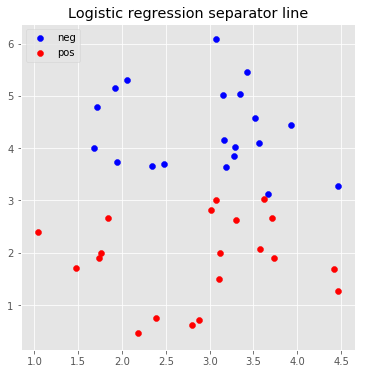

In [564]:
def lm_sim(N = 20):
    """simulate a binary response and two predictors"""
    X1 = (np.random.randn(N*2)).reshape((N,2)) + np.array([3,2])
    X0 = (np.random.randn(N*2)).reshape((N,2)) + np.array([3,4])
    y = - np.ones(N*2)
    y[:N]=1
    X = np.vstack((X1,X0))
    return X, y, X0, X1


X_sim, y_sim, X0, X1 = lm_sim()
plt.scatter(X0[:,0],X0[:,1],c='b',label='neg')
plt.scatter(X1[:,0],X1[:,1],c='r',label='pos')
plt.title("Logistic regression separator line")
_ = plt.legend(loc=2)

This dataset is generated such that only the second X variable (on the Y-axis in the plot) is influencing the probability of a point being positive or negative.  There are also only 20 data points.  Let's fit a logistic regression with both predictors and also only the relevant predictor, then plot the separator line.

In [565]:
def sep_lr(T,lr):
    T = np.linspace(0,5,100)
    beta1 = lr_sim.coef_[0,0]
    beta2 = lr_sim.coef_[0,1]
    beta0 = lr_sim.intercept_
    return -(beta0 + beta1*T) / beta2

In [ ]:
lr_sim = linear_model.LogisticRegression()
lr_sim.fit(X_sim,y_sim)

mults=0.8
T = np.linspace(0,7,100)
x2hat = sep_lr(T,lr_sim)

X_other = X_sim.copy()
X_other[:,0] = 0.
lr_sim = linear_model.LogisticRegression()
lr_sim.fit(X_other,y_sim)
x1hat = sep_lr(T,lr_sim)

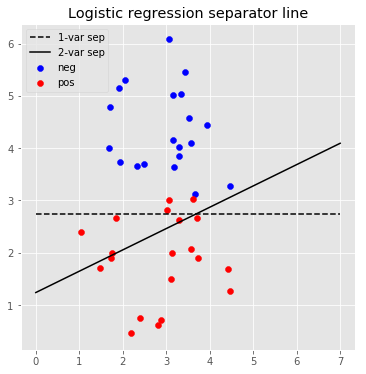

In [567]:
plt.scatter(X0[:,0],X0[:,1],c='b',label='neg')
plt.scatter(X1[:,0],X1[:,1],c='r',label='pos')
plt.plot(T,x1hat,'--',c='k',label='1-var sep')
plt.plot(T,x2hat,c='k',label='2-var sep')
plt.title("Logistic regression separator line")
_ = plt.legend(loc=2)

We see that due to the randomness of the data points the classifier that uses both predictors is significantly perturbed and will result in a higher test error than the one that only uses the relevant variable.  This is an example of how adding irrelevant variables can hurt your prediction because the classifier will begin to fit to the data.  This problem is pronounced when you have a small amount of data or you have many predictors. 

One remedy to this is to order your predictor variables by some measure that you think indicates importance.  Then you can select the best K variables and look at your test error to determine K.  K is called a tuning parameter, and to select it you have to compare test errors, because otherwise you will not necessarily detect overfitting.  In Scikit-learn several methods are available for selecting best K predictors, and we will focus on using the method ``feature_selection.SelectKBest``.  By default this considers a single predictor variable at a time, then performs an ANOVA on that predictor with the binary response variable as the independent variable (it flips the roles of the response and predictors).  Then it computes the F score which when maximized gives the best predictor variable.  Choosing the top K F scores gives you the best K variables.  In the following code, we use the best K predictors to transform the training and test set.  Like in other transformations, it is important to fit it only on the training data.

In [518]:
def get_prec(lr,X,y,K):
    """Find precision for top K"""
    
    lr_score = X @ lr.coef_[0,:]
    sc_sorted_id = np.argsort(lr_score)[::-1]
    return np.mean(y[sc_sorted_id[:K]] == 1) 

In [519]:
def test_kbest(X_tr,y_tr,X_te,y_te,k,prec_perc = .115):
    """Training and testing only on k-best variables"""
    
    ## Training
    # Feature Selection
    skb = feature_selection.SelectKBest(k=k)
    skb.fit(X_tr,y_tr)
    X_tr_kb = skb.transform(X_tr)
    
    # Fitting
    lr = linear_model.LogisticRegression()
    lr.fit(X_tr_kb,y_tr)
    yhat_tr = lr.predict(X_tr_kb)
    prec_K = int(prec_perc * len(y_tr))
    tr_prec = get_prec(lr,X_tr_kb,y_tr,prec_K)
    tr_error = (yhat_tr != y_tr).mean()

    ## Testing
    X_te_kb = skb.transform(X_te)
    yhat_te = lr.predict(X_te_kb)
    prec_K = int(prec_perc * len(y_te))
    te_prec = get_prec(lr,X_te_kb,y_te,prec_K)
    te_error = (yhat_te != y_te).mean()
    
    return tr_error, te_error, tr_prec, te_prec

In the above code, we return the 0-1 errors and the precision when we recommend the best 11.5% of the scores.  This number is chosen because it is the proportion of positives in the training set.

In [520]:
errors = [test_kbest(X_tr,y_tr,X_te,y_te,k) for k in range(1,X_tr.shape[1]+1)]
train_error, test_error, tr_prec, te_prec = zip(*errors)

We can plot the 0-1 error and see how it responds to the tuning parameter K.

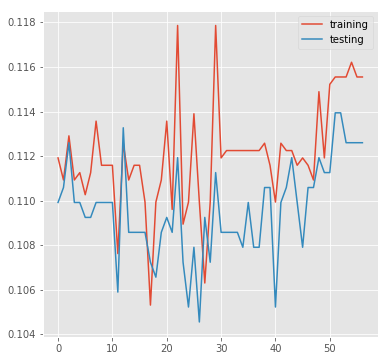

In [522]:
plt.plot(train_error,label='training')
plt.plot(test_error,label='testing')
plt.legend()

Unfortunately, as before the 0-1 error is not very helpful as a metric, and does not deviate significantly from the  just predicting all negatives.  Looking at precision is somewhat more useful, and we can see that it increases in a noisy way, until it drops significantly as we increase K.  This is consistent with an overfitting-underfitting tradeoff.  At the beginning we are underfitting because we have not selected all of the important predictor variables, but then we start to overfit when K gets large.

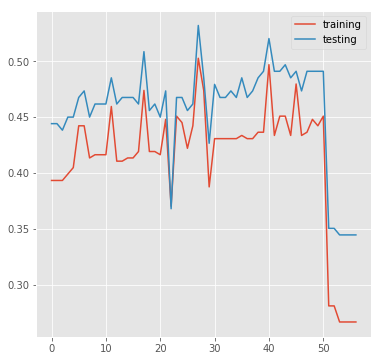

In [523]:
plt.plot(tr_prec,label='training')
plt.plot(te_prec,label='testing')
plt.legend()

Let's look at the variables that are selected in the best 10 and best 25.

In [524]:
skb = feature_selection.SelectKBest(k=10)
skb.fit(X_tr,y_tr)
set(var_names[skb.get_support()])

{'contact', 'duration', 'month', 'pdays', 'poutcome', 'previous'}

In [525]:
skb = feature_selection.SelectKBest(k=25)
skb.fit(X_tr,y_tr)
set(var_names[skb.get_support()])

{'age',
 'balance',
 'campaign',
 'contact',
 'duration',
 'housing',
 'job',
 'loan',
 'month',
 'pdays',
 'poutcome',
 'previous'}

It seems that duration is included in both but many other variables are added in addition to age and balance.  We can also compare the PR curve for the test error for different models.

In [529]:
X_tr_kb = skb.transform(X_tr)
lr = linear_model.LogisticRegression()
lr.fit(X_tr_kb,y_tr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

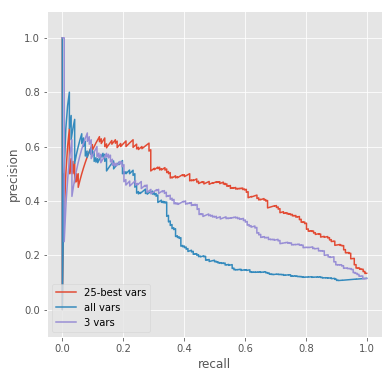

In [533]:
X_te_kb = skb.transform(X_te)
z_log = lr.predict_proba(X_te_kb)[:,1]
plt.figure(figsize=(6,6))
prec_skb, rec_skb, _ = metrics.precision_recall_curve(y_te,z_log)
plt.plot(rec_skb,prec_skb,label='25-best vars')
plt.plot(rec,prec,label='all vars')
plt.plot(rec_lr,prec_lr,label='3 vars')
plt.xlabel('recall')
plt.ylabel('precision')
plt.ylim([-.1,1.1])
plt.legend(loc=3)
_ = plt.plot()

It seems that the 25 best variables model has a higher precision at most recalls, which means that we can predict more positives while maintaining a good prediction precision.